Цель:
Исследовать поведение пользователей в обновлённом приложении Quiz Freeze

Задачи:
В рамках проверки гипотез вам необходимо решить три задачи:

1) Определить, насколько обучение сокращает время прохождения этапов игры.
2) Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3) Определить, насколько прозрачен процесс взаимодействия с игрой.

Подготовка данных:

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
events_df = pd.read_csv('7_4_Events.csv',sep=',')
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585


In [74]:
events_df['start_time']=pd.to_datetime(events_df['start_time'],errors='coerce')

mask1=events_df['start_time']>='2018-01-01'
mask2=events_df['start_time']<'2019-01-01'
mask3=events_df['event_type']=='registration'
users_2018=events_df[mask1&mask2&mask3]['user_id'].to_list()
events_df=events_df[events_df['user_id'].isin(users_2018)]

events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836


In [75]:
purchase_df = pd.read_csv('7_4_Purchase.csv',sep=',')
purchase_df.head()

,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


In [76]:
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], errors='coerce')
purchase_df = purchase_df[purchase_df['user_id'].isin(users_2018)]
purchase_df.head()


,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03 18:53:43,100
1172,16846,27865,2018-01-04 14:46:10,250
1174,16848,27911,2018-01-07 08:19:12,50
1175,16849,27910,2018-01-07 12:11:34,100
1176,16850,27940,2018-01-07 13:16:41,200


In [77]:
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df.head()


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
51405,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
51406,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
51407,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
51408,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
51409,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


Шаг 1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

Гипотеза № 1. По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Согласно поставленной задаче, необходимо выделить группы:  

- пользователи, которые прошли обучение (у которых есть событие tutorial_finish)  
- пользователи, которые не начинали обучение (у которых отсутствует событие tutorial_start) 
- пользователи, которые начали, но не окончили обучение (у которых отсутствует событие tutorial_finish) - этого не требовалось, можно считать это нашим бонусом для заказчика  🙂

In [78]:
#Создадим множество пользователей, которые завершили обучение:
set_finish_tutorial_users=set(events_df[events_df['event_type']=='tutorial_finish'].user_id)
len(set_finish_tutorial_users)

10250

In [79]:
##Создадим множество пользователей, которые не начинали обучение:
set_registered_users=set(events_df.user_id)
set_start_tutorial_users=set(events_df[events_df['event_type']=='tutorial_start'].user_id)
set_not_started_tutorial_users=set_registered_users.difference(set_start_tutorial_users)
len(set_not_started_tutorial_users)

8068

In [80]:
##Создадим множество пользователей, которые начали ,но не закончили обучение:
set_started_not_finished_users=set_start_tutorial_users.difference(set_finish_tutorial_users)
len(set_started_not_finished_users)

1608

Далее нам необходимо выделить этапы по которым мы будем сравнивать наши группы, поскольку этап прохождения обучения актуален только для двух групп, то мы его не будем анализировать (но он попадет в этап полного пути для групп). По итогу выделяем следующие этапы:  
- start registration -> start level choice (для группы не начавшей обучение), start registration -> tutorial start (для окончивших обучение)
- start level choice -> start pack choice  
- start pack_choice -> start purchase  
- start registration -> start purchase (посмотреть весь путь, не отдаляет ли наше обучение от момента покупки)

Так в первом этапе для группы не начавшей обучение - это время от начала регистрации до выбора уровня сложности, для второй и третьей группы - это время с начала регистрации до начала обучения. Но по сути это время затраченное на регистрацию в приложении до следующего события, поэтому сравнение релевантное.

In [81]:
#Создадим список интересующих нас времен по этапам:
time_stages=['registration_duration', 'level_choice_duration', 'pack_choice_duration', 'until_purchase_duration']


In [82]:
#Создадаим датафрейм с интересующими нас данными о времени:
# Мы выбираем минимальное время - то есть самое первое для данного события, если событие могло произойти несколько раз
users_time_df=total_events_df.pivot_table(values=['start_time'], \
                                          index=['user_id'], columns=['event_type'], aggfunc='min').copy()
print(len(users_time_df))
users_time_df.reset_index(inplace=True)
users_time_df.columns=['user_id', 'level_choice','pack_choice', 'purchase', 'registration', \
                       'tutorial_finish', 'tutorial_start']
users_time_df.head()

19926


,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


In [83]:
#Поскольку нас интересуют разные группы и мы будем датафреймы преобразовывать - разделим его на группы:
users_time_df1=users_time_df[users_time_df['user_id'].isin(set_finish_tutorial_users)].copy()
users_time_df1.reset_index(drop=True, inplace=True)
users_time_df2=users_time_df[users_time_df['user_id'].isin(set_not_started_tutorial_users)].drop(['tutorial_finish', 'tutorial_start'], axis=1).copy()
users_time_df2.reset_index(drop=True, inplace=True)
users_time_df3=users_time_df[users_time_df['user_id'].isin(set_started_not_finished_users)].drop(['tutorial_finish'], axis=1).copy()
users_time_df3.reset_index(drop=True, inplace=True)

In [84]:
# Добавляем интересующие нас колонки с продолжительностью для каждого этапа:
users_time_df1['registration_duration']=(users_time_df1['tutorial_start']-users_time_df1['registration'])
users_time_df1['level_choice_duration']=(users_time_df1['pack_choice']-users_time_df1['level_choice'])
users_time_df1['pack_choice_duration']=(users_time_df1['purchase']-users_time_df1['pack_choice'])
users_time_df1['until_purchase_duration']=(users_time_df1['purchase']-users_time_df1['registration'])

users_time_df2['registration_duration']=(users_time_df2['level_choice']-users_time_df2['registration'])
users_time_df2['level_choice_duration']=(users_time_df2['pack_choice']-users_time_df2['level_choice'])
users_time_df2['pack_choice_duration']=(users_time_df2['purchase']-users_time_df2['pack_choice'])
users_time_df2['until_purchase_duration']=(users_time_df2['purchase']-users_time_df2['registration'])

users_time_df3['registration_duration']=(users_time_df3['tutorial_start']-users_time_df3['registration'])
users_time_df3['level_choice_duration']=(users_time_df3['pack_choice']-users_time_df3['level_choice'])
users_time_df3['pack_choice_duration']=(users_time_df3['purchase']-users_time_df3['pack_choice'])
users_time_df3['until_purchase_duration']=(users_time_df3['purchase']-users_time_df3['registration'])

In [85]:
#Анализ времени прохождения рассматриваемых этапов пользователями прошедших обучение:
users_time_df1.describe(include='timedelta')

,registration_duration,level_choice_duration,pack_choice_duration,until_purchase_duration
count,10250,5176,1447,1447
mean,0 days 04:31:04.938146341,0 days 00:05:18.146058732,3 days 17:17:59.641326883,4 days 00:30:03.247408431
std,0 days 04:11:24.828137380,0 days 00:02:44.449118501,2 days 04:31:59.804658578,2 days 04:47:29.946150698
min,0 days 00:00:34,0 days 00:00:19,0 days 00:44:50,0 days 04:36:58
25%,0 days 01:17:55.500000,0 days 00:03:05,1 days 21:16:05.500000,2 days 04:09:55
50%,0 days 03:13:48,0 days 00:04:58,3 days 12:15:56,3 days 19:04:59
75%,0 days 06:37:27.750000,0 days 00:07:11,5 days 08:53:44.500000,5 days 15:46:14
max,1 days 16:03:46,0 days 00:15:48,10 days 18:33:59,11 days 00:35:04


In [86]:
users_time_df2.describe(include='timedelta')

,registration_duration,level_choice_duration,pack_choice_duration,until_purchase_duration
count,98,74,22,22
mean,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090,4 days 09:06:01.909090909
std,0 days 03:41:00.594664298,0 days 00:03:01.230146431,2 days 04:58:40.602573417,2 days 05:12:16.748091626
min,0 days 00:09:26,0 days 00:00:48,0 days 09:35:48,0 days 09:59:07
25%,0 days 02:15:28.500000,0 days 00:03:09.750000,2 days 15:49:22,2 days 21:31:31
50%,0 days 04:56:05.500000,0 days 00:04:46.500000,4 days 04:38:42,4 days 11:29:09
75%,0 days 08:24:01,0 days 00:07:11.250000,5 days 23:34:55.750000,6 days 02:28:47.750000
max,0 days 18:34:21,0 days 00:13:32,7 days 11:56:49,7 days 16:46:20


In [87]:
users_time_df3.describe(include='timedelta')

,registration_duration,level_choice_duration,pack_choice_duration,until_purchase_duration
count,1608,487,131,131
mean,0 days 05:25:02.892412935,0 days 00:05:05.295687885,3 days 21:14:46.908396946,4 days 05:32:53.213740458
std,0 days 04:33:22.569938660,0 days 00:02:35.198952502,2 days 05:36:49.125505005,2 days 05:17:50.662967411
min,0 days 00:02:34,0 days 00:00:24,0 days 05:29:38,0 days 13:58:56
25%,0 days 01:45:47,0 days 00:03:04,1 days 22:35:28.500000,2 days 05:12:55.500000
50%,0 days 04:23:49.500000,0 days 00:04:48,3 days 19:11:35,4 days 05:26:14
75%,0 days 07:50:33,0 days 00:06:37,5 days 13:41:45,6 days 00:07:43.500000
max,1 days 06:03:23,0 days 00:15:39,8 days 15:27:43,8 days 21:14:27


In [88]:
#Преобразуем интересующие нас колонки с продолжительностью для каждого этапа (необходимо для построения графиков):
users_time_df1['registration_duration']=users_time_df1['registration_duration']/pd.Timedelta('1 hour')
users_time_df1['level_choice_duration']=users_time_df1['level_choice_duration']/pd.Timedelta('1 minute')
users_time_df1['pack_choice_duration']=users_time_df1['pack_choice_duration']/pd.Timedelta('1 day')
users_time_df1['until_purchase_duration']=users_time_df1['until_purchase_duration']/pd.Timedelta('1 day')

users_time_df2['registration_duration']=users_time_df2['registration_duration']/pd.Timedelta('1 hour')
users_time_df2['level_choice_duration']=users_time_df2['level_choice_duration']/pd.Timedelta('1 minute')
users_time_df2['pack_choice_duration']=users_time_df2['pack_choice_duration']/pd.Timedelta('1 day')
users_time_df2['until_purchase_duration']=users_time_df2['until_purchase_duration']/pd.Timedelta('1 day')

users_time_df3['registration_duration']=users_time_df3['registration_duration']/pd.Timedelta('1 hour')
users_time_df3['level_choice_duration']=users_time_df3['level_choice_duration']/pd.Timedelta('1 minute')
users_time_df3['pack_choice_duration']=users_time_df3['pack_choice_duration']/pd.Timedelta('1 day')
users_time_df3['until_purchase_duration']=users_time_df3['until_purchase_duration']/pd.Timedelta('1 day')

C:\Users\Home\AppData\Local\Temp\ipykernel_3472\111734749.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=melted_df, x='Duration Type', y='Duration', hue='group', ci='sd')


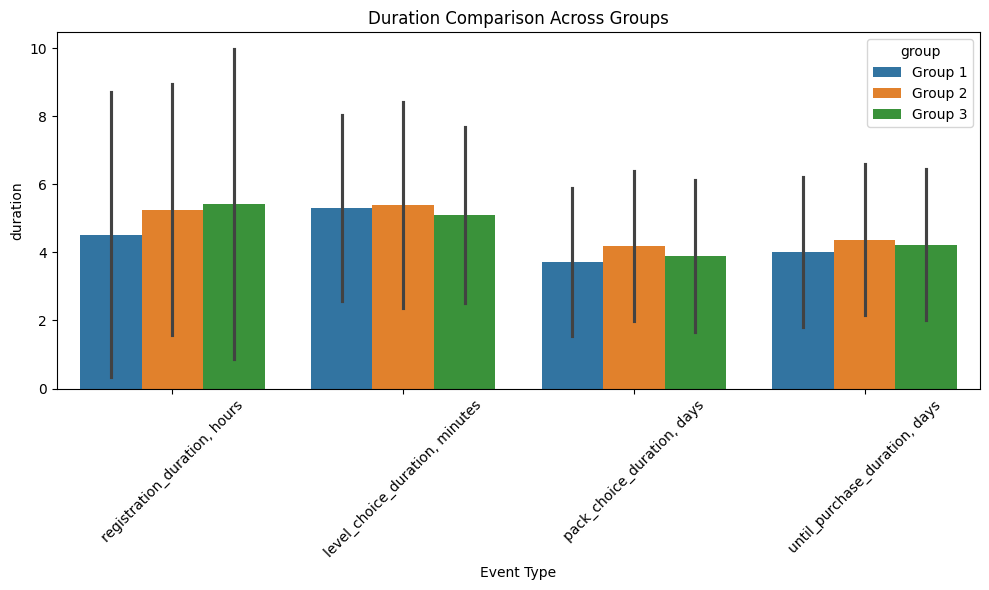

In [89]:
# Add group identifiers
users_time_df1['group'] = 'Group 1'
users_time_df2['group'] = 'Group 2'
users_time_df3['group'] = 'Group 3'

# Combine into one DataFrame
combined_df = pd.concat([users_time_df1, users_time_df2, users_time_df3], ignore_index=True)

# Keep only duration columns + group
duration_columns = ['registration_duration', 'level_choice_duration', 'pack_choice_duration', 'until_purchase_duration']
duration_df = combined_df[['group'] + duration_columns]
duration_df.columns = ['group', 'registration_duration, hours', 'level_choice_duration, minutes', 'pack_choice_duration, days', 'until_purchase_duration, days']

# Melt into long format for seaborn
melted_df = duration_df.melt(id_vars='group', var_name='Duration Type', value_name='Duration')

# Drop NaNs (optional)
melted_df.dropna(subset=['Duration'], inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='Duration Type', y='Duration', hue='group', ci='sd')

plt.title('Duration Comparison Across Groups')
plt.ylabel('duration')
plt.xlabel('Event Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Гипотеза № 1. По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
 Вывод: Гипотеза верна. Действительно ,группа которая прошла обучение быстрее проходит этапы игры.

Шаг2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

Гипотеза №2 Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

In [90]:
total_events_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
51405,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
51406,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
51407,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
51408,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
51409,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


In [91]:
#Создадим датафрейм с необходимыми нам параметрами:
tut_attemps_df=total_events_df.groupby('user_id')['tutorial_id'].nunique().reset_index()
tut_attemps_df.columns=['user_id', 'tutorial_attemps']

#Создадим колонку purchase со значением 1 если купил платный пакет, 0 - если покупки не было:
set_purchase_users=set(purchase_df['user_id'])
tut_attemps_df['purchase']=tut_attemps_df.apply(lambda x: 1 if x['user_id'] in set_purchase_users \
                                                          else 0, axis=1)
tut_attemps_df.head()



,user_id,tutorial_attemps,purchase
0,27832,0,0
1,27833,1,0
2,27834,1,0
3,27835,1,0
4,27836,2,0


In [92]:
# Преобразуем датафрейм сразу меняя названия колонок:
grouped_df=tut_attemps_df.groupby('tutorial_attemps').agg(users=pd.NamedAgg(column='user_id', aggfunc='count'),\
                                                           purchase_users=pd.NamedAgg(column='purchase', aggfunc='sum'))
grouped_df

,users,purchase_users
tutorial_attemps,,
0,8068,22
1,9103,1207
2,1589,218
3,427,51
4,221,30
5,109,16
6,116,14
7,94,12
8,86,13


In [93]:
grouped_df['conversion'] = ((grouped_df['purchase_users'] / grouped_df['users']) * 100).round(2)
grouped_df

,users,purchase_users,conversion
tutorial_attemps,,,
0,8068,22,0.27
1,9103,1207,13.26
2,1589,218,13.72
3,427,51,11.94
4,221,30,13.57
5,109,16,14.68
6,116,14,12.07
7,94,12,12.77
8,86,13,15.12


C:\Users\Home\AppData\Local\Temp\ipykernel_3472\724661473.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=grouped_df, x='conversion', y='tutorial_attemps', ci='sd')


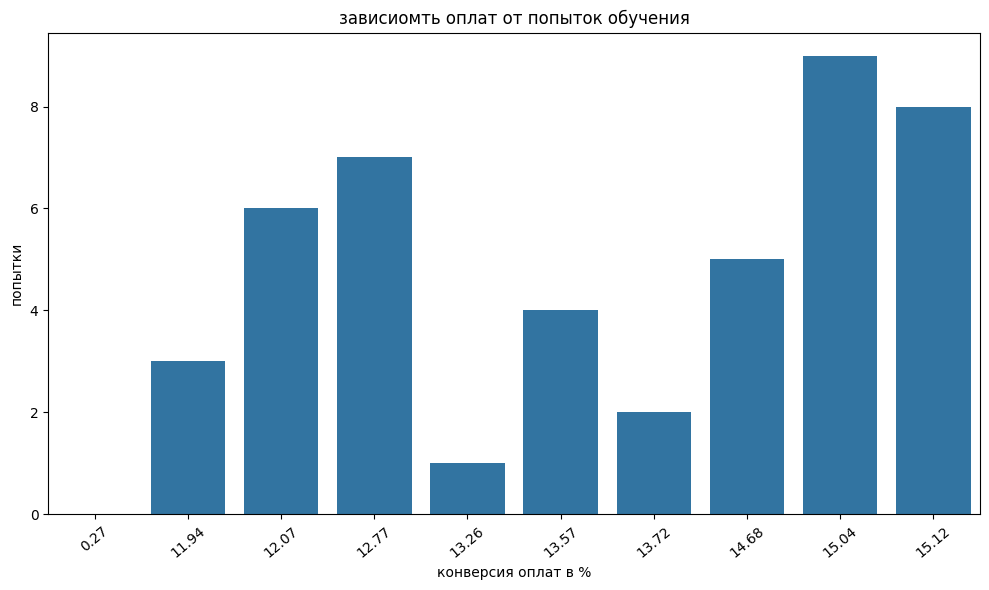

In [94]:
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_df, x='conversion', y='tutorial_attemps', ci='sd')

plt.title('зависиомть оплат от попыток обучения')
plt.ylabel('попытки')
plt.xlabel('конверсия оплат в %')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()



Гипотеза №2.Кажется, повторное прохождение обучения положительно влияет на оплату, верно? Не совсем так , конверсия высокая и при единоразовом прохождении и при 9 попытке. Скорее всего единоразового прохождения обучения не достаточно и клиенты вынуждены проходить обучение повторно ,что увеличивает время до оплаты. 

Шаг 3 Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Гипотеза №3. Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?
Ну что, готовы как следует потрудиться?

In [95]:
#Попробуем воспользоваться нашим готовым датафреймом с первыми событиями времени по этапам для всех пользователей:
users_time_df[(users_time_df.tutorial_start-users_time_df.level_choice)>pd.Timedelta(0)]

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start


Отсутствие значений в полученном результате свидетельствует, что все пользователи, выбравшие уровень сложности тренировок, первоначально проходили обучение. Попробуем проанализировать возможные варианты, когда существуют события возврата к обучению после выбора уровня сложности тренировки с использованием первоначального датафрейма events_df.  

Создадим два датафрейма tutorial_start_df и level_choice_df только с интересующими нас колонками, объединим их по пользователям и найдем разницу во времени между началом обучения и выбором сложности уровня тренировок. Оставим только те записи, где она положительная (где обучение после выбора уровня сложности тренировок) - получили датафрейм с интересующими нас пользователями.

In [96]:
tutorial_start_df=events_df[events_df['event_type']=='tutorial_start'][['start_time', 'user_id']]\
.rename(columns={'start_time':'tutorial_start_time'})
level_choice_df=events_df[events_df['event_type']=='level_choice'][['start_time', 'user_id']]\
.rename(columns={'start_time':'level_choice_time'})
focus_group_df=pd.merge(tutorial_start_df, level_choice_df, on='user_id')
focus_group_df['timedelta']=focus_group_df['tutorial_start_time']-focus_group_df['level_choice_time']
focus_group_df=focus_group_df[focus_group_df.timedelta>pd.Timedelta(0)].reset_index(drop=True)
focus_group_df.head()

,tutorial_start_time,user_id,level_choice_time,timedelta
0,2018-01-02 07:08:00,27845,2018-01-02 06:19:18,0 days 00:48:42
1,2018-01-02 09:01:51,27842,2018-01-02 08:46:03,0 days 00:15:48
2,2018-01-02 18:08:01,27842,2018-01-02 08:46:03,0 days 09:21:58
3,2018-01-02 20:34:31,27852,2018-01-02 18:39:44,0 days 01:54:47
4,2018-01-03 11:17:41,27862,2018-01-03 04:19:32,0 days 06:58:09


In [97]:
#Количество и процент от общего числа ошибившихся пользователей
print('Количество пользователей выбравших обучение после выбора уровня тренировок: {}'.format(focus_group_df.user_id.nunique()))
print('Процент данных пользователей от общего числа зарегистрированных уникальных пользователей: {:.2%}'\
      .format(focus_group_df.user_id.nunique()/events_df.user_id.nunique()))
print('Процент данных пользователей от тех, кто проходил обучение: {:.2%}'\
      .format(focus_group_df.user_id.nunique()/len(set_start_tutorial_users)))

Количество пользователей выбравших обучение после выбора уровня тренировок: 1386
Процент данных пользователей от общего числа зарегистрированных уникальных пользователей: 6.96%
Процент данных пользователей от тех, кто проходил обучение: 11.69%


Гипотеза 3 Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение? Да, клиент повторно возвращается к обучению.

Вывод по общему анализу данных: Данные показывают, что обучение сокращает время прохождения этапов игры и напрямую влияет на оплату, независимо от этапа, на котором оно было пройдено.

Обнаружена проблема с непрозрачностью пользовательского пути: игроки часто проходят обучение повторно. Это сигнализирует о необходимости улучшения обучающего контента.

Предлагается сделать обучение обязательным этапом после регистрации. Краткий, но информативный обучающий модуль позволит ускорить прохождение игры и повысить конверсию.